### Defocused probe ptychography

In this tutorial notebook, we will perform both differential phase contrast (DPC) and ptychographic phase reconstructions from a simulated 4D-STEM dataset.

### Downloads

* [4D-STEM dataset](https://drive.google.com/file/d/1uyeQAQa4DaMwHqN9EHQFCMKAve0_Fgfz/view?usp=share_link)
* [vacuum probe intensity](https://drive.google.com/file/d/1xJgQoxhWMBbtknwRfqB_BkULvgiJe-c1/view?usp=share_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Stephanie Ribet (sribet@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)

The 4D-STEM dataset used here was simulated by Colin Ophus using the reference implementation of partitioned PRISM which can be found at the [Github repo for superPRISM](https://github.com/cophus/superPRISM). We have also added the common experiment artifacts of probe descan which varies over the field of view and shot noise.

Updated 2023 Oct 31

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.8


In [2]:
file_path = 'data/'
file_data = file_path + 'ptycho_sim_01_data.h5'
file_probe = file_path + 'ptycho_sim_01_probe.h5'

### load the data

In [3]:
dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (32, 32, 200, 200) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [4]:
probe = py4DSTEM.read(file_probe)
probe

DiffractionSlice( A 2-dimensional array of shape (200, 200) called 'diffractionslice',
                  with dimensions:

                      dim0 = [0,1,2,...] pixels
                      dim1 = [0,1,2,...] pixels
)

Let's plot some of the probe positions:

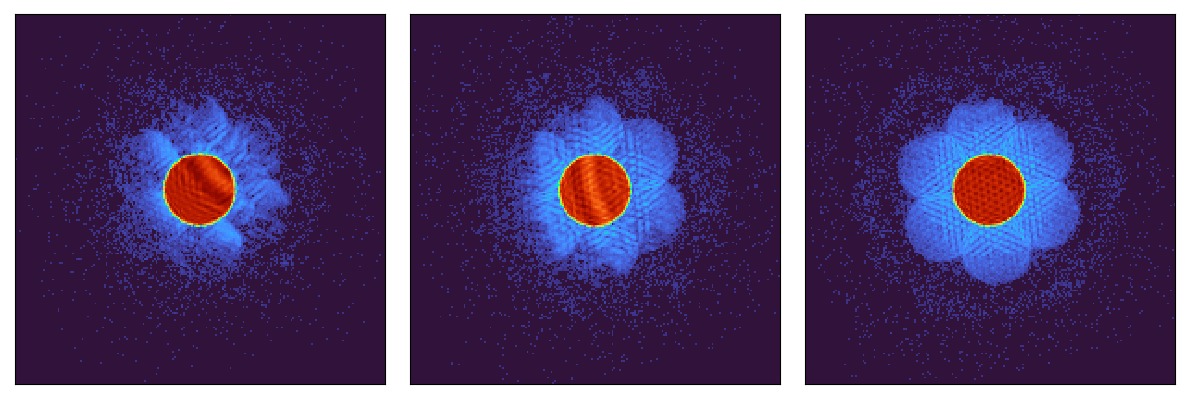

In [5]:
py4DSTEM.show(
    [
        dataset.data[11,24],
        dataset.data[18,24],
        dataset.data[11,12],
    ],
    cmap='turbo',
    vmax=1,
    power=0.333,
    axsize=(4,4),
    ticks=False,
)

### Calibration

We will manually enter the diffraction space sampling and the real space step size between adjacent STEM probes:

In [6]:
dataset.calibration.set_Q_pixel_size(0.025)
dataset.calibration.set_Q_pixel_units('A^-1')
dataset.calibration.set_R_pixel_size(5.0)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.025
             R_pixel_size:    5.0
             Q_pixel_units:   A^-1
             R_pixel_units:   A
)

# DPC

First, we perform the preprocessing steps. These include:
1. measuring the center of mass (CoM) for all probe postions.
2. fitting the probe descan to a plane wave or another function.
3. determining the best-fit rotation between real and reciprocal space.
4. calculating the corrected CoM images.

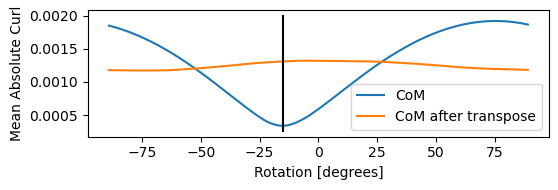

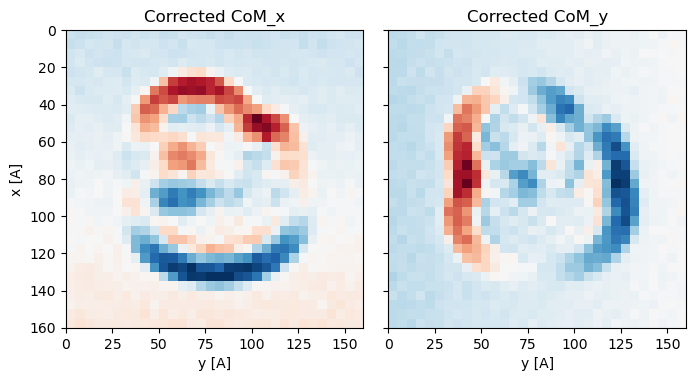

In [7]:
dpc = py4DSTEM.process.phase.DPCReconstruction(
    datacube=dataset,
    energy=80e3,
    verbose=False,
    #device='gpu',
).preprocess()

Next we perform the DPC reconstruction:

Reconstructing phase:  84%|██████████████████████████████████████████████████████████████████▋            | 27/32 [00:00<00:00, 276.69 iter/s]


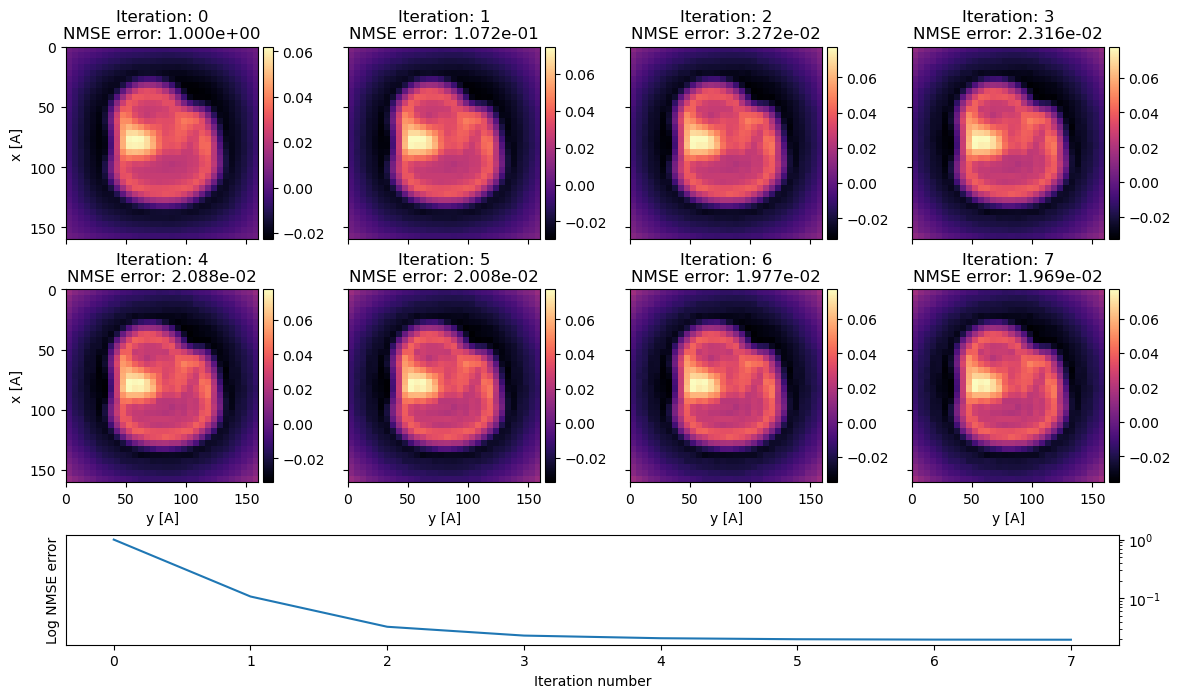

In [8]:
dpc = dpc.reconstruct(
    reset=True,
    progress_bar=True,
    store_iterations=True,
    max_iter=32
).visualize(iterations_grid='auto')

The reconsruction clearly shows the object on the substrate. However, the resolution is limited to the STEM probe sampling - we only recover one phase value per probe position. In order to perform superresolution imaging (i.e. recover spatial frequencies outside of the numerical aperture / probe semiangle), we will need to peform a ptychographic reconstruction.

# Ptychography

We perform similar pre-processing for ptychography as we do for DPC.  
Getting a good guess for the rotation between real space and diffraction space is essential to getting a good reconstruction in defocused probe ptychography.

Best fit rotation = -15 degrees.
No need to transpose diffraction intensities.


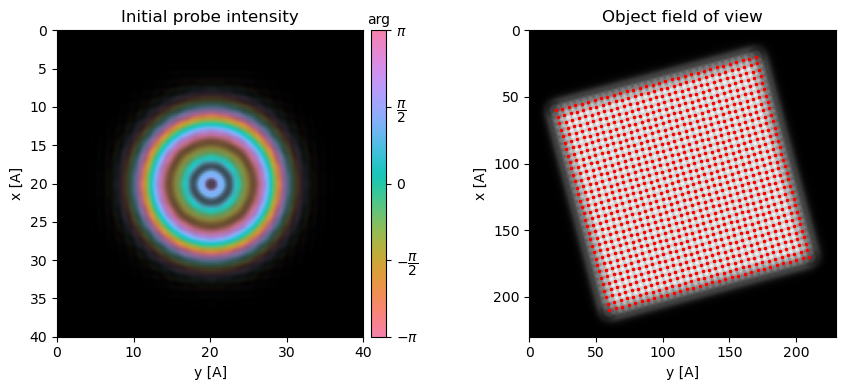

In [9]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset,
    verbose=True,
    energy=80e3,
    defocus=600,
    vacuum_probe_intensity = probe.data,
    #device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation = False,
    plot_probe_overlaps = True,
    power = 2,
)

Next, we perform the ptychographic reconstruction.  
There are various options we can tune below, but this reconstruction converges quite rapidly due to the sample being close to a weak phase object (the thickest region of the sample consists of 4 graphene layers).

Performing 128 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.0.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████| 128/128 [00:15<00:00,  8.03 iter/s]


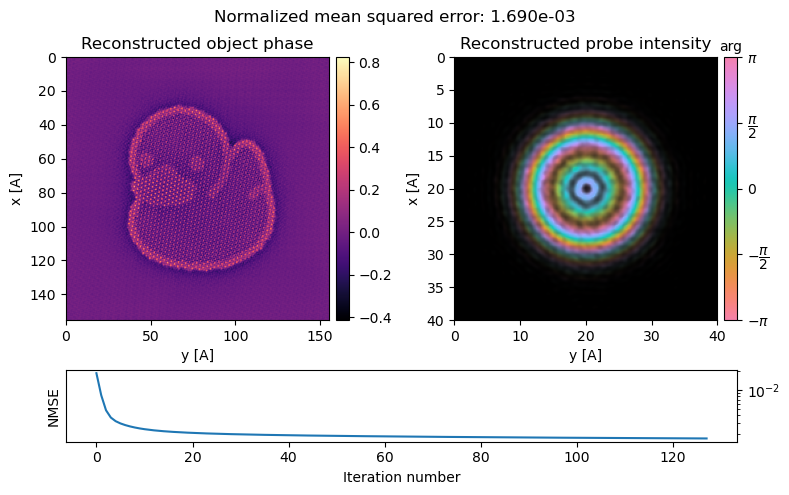

In [10]:
ptycho = ptycho.reconstruct(
    reset=True,
    store_iterations = True,
    max_iter = 128,
    normalization_min=0.0,
).visualize(
    #plot_fourier_probe=True,
)

We then plot the final reconstructed phase:

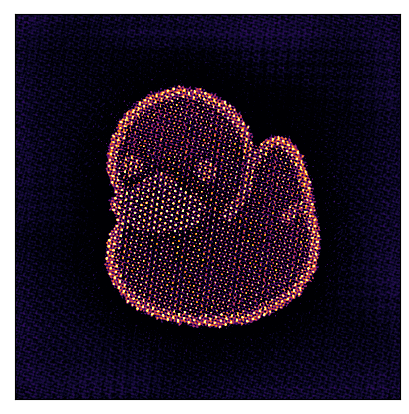

In [12]:
py4DSTEM.show(
    np.angle(ptycho.object_cropped),
    vmin=0.33,
    vmax=0.99,
    cmap='inferno',
    ticks=False,
)